# Practical Assignment 3

Authors: Abdullahi Ali, Pieter Wolfert

Recurrent neural networks can deal with sequential data (timeseries). In this assignment a recurrent neural network is implemented which computes the current outpus as the sum of the two previous inputs. 

First we deal with the imports:

In [1]:
from __future__ import division

import numpy as np
import chainer
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.datasets import TupleDataset
import chainer.training as training
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from chainer import iterators
from chainer.cuda import to_cpu

### Implementation of RNN
To work with continous data instead of a classifier a regressor is build on top of the neural network chain. The RNN has one Long Short Term Memory layer and one fully connected layer. It is important to reset the state of the RNN after every epoch. 

In [2]:
class RNN(Chain):
    """
    
    RNN implementation consisting of 1 lstm layer 
    and one fully connected layer
    
    """
    def __init__(self):
        super(RNN, self).__init__()
        with self.init_scope():
            self.lstm = L.LSTM(None,1) 
            self.linear = L.Linear(None,1)
                
    def reset_state(self):
        self.lstm.reset_state()

    def __call__(self, x):
        # Given the current input compute the sum
        h = self.lstm(x)
        y = self.linear(h)
        return y
                

class Regressor(Chain):
    """

    Regressor chain on top of Neural Network chain 
    for accuracy evaluation and prediction
 
    """
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.mean_squared_error(y, t)
        return loss

### Backpropagation and model updating

The backprop through time updater (BPTT) is an extension of the chainer StandardUpdater which updates the network (and does a backpropagation) and evaluates with the test set. 

In [3]:
class BPTTUpdater(chainer.training.StandardUpdater):

    def __init__(self, train_iter,  optimizer, bprop_len, rnn):
        super(BPTTUpdater, self).__init__(train_iter, optimizer)
        self.bprop_len = bprop_len

    # The core part of the update routine can be customized by overriding.
    def update_core(self):
        train_loss = []
        test_loss = []
        # When we pass one iterator and optimizer to StandardUpdater.__init__,
        # they are automatically named 'main'.
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        count = 0
        total_loss = 0
        # Progress the dataset iterator for bprop_len 
        for i in range(self.bprop_len):
            count += 1
            # Get the next batch 
            batch = train_iter.__next__()
            
            x, t = self.converter(batch)
            model.reset_state()
            # Compute the loss at this time step and accumulate it
            loss = optimizer.target(chainer.Variable(x), chainer.Variable(t))
            total_loss += loss
            if count % 30 == 0:
                optimizer.target.cleargrads()  # Clear the parameter gradients
                total_loss.backward()  # Backprop
                total_loss.unchain_backward()
                optimizer.update()  # Update the parameters
                train_loss.append(loss.data)
                #calculate test loss
                test_batch = test_iter.next()
                xtest, ttest = self.converter(test_batch)
                # Forward the test data
                loss_test = regressor(xtest, ttest)
                test_loss.append(loss_test.data)
        return train_loss, test_loss

#### Data creator method, as given in the course.

In [4]:
def create_data(n=3000):
    X = np.random.rand(n, 1).astype('float32')
    T = np.sum(np.hstack((X[0:-1], X[1:])), axis=1)
    T = np.hstack([0, T[0:]]).astype('float32')
    T = T.reshape([n, 1])

    return TupleDataset(X, T)

#### Visualisation function
A function to visualize training and test loss per epoch. 

In [5]:
def visualize_loss(train_loss, test_loss, nr_epochs=20):
    matplotlib.style.use('ggplot')
    figure = plt.figure(figsize=(10, 8))
    ax = figure.add_subplot(111)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    xticks = np.arange(1, nr_epochs+1, 1)
    ax.set_xticks(xticks)
    epochs = range(1, nr_epochs + 1)
    train, = plt.plot(epochs, train_loss, 'b', label='train loss')
    test, = plt.plot(epochs, test_loss, 'r', label='test loss')
    plt.legend([train, test], ['train loss', 'test loss'])
    plt.show()

#### The training loop 
The training loop at the bottom of the cell is at the core of training the RNN. First the data is loaded and iterators are instantiated. As learning rate we choose 0.02, which differs from the standard learning rate. 

In [6]:
#set the number of epochs
nr_epochs = 20
#retrieve the data
train_data = create_data()
test_data = create_data()
inputs, labels = np.array([tup[0] for tup in test_data]), np.array([tup[1] for tup in test_data])

#instantiating iterators
train_iter = iterators.SerialIterator(train_data, 1)
test_iter = iterators.SerialIterator(test_data, 1,repeat=False, shuffle=False)

#instantiating a model
model = RNN()
regressor = Regressor(model)

#choosing an optimizer
optimizer = chainer.optimizers.SGD(lr=0.02)
optimizer.setup(regressor)
updater = BPTTUpdater(train_iter, optimizer,3000, model)
train_loss, test_loss = [], []
#update network (evaluation is done within the loop)
for i in range(nr_epochs):
    loss_train, loss_test = updater.update_core()
    print(np.mean(loss_train), np.mean(loss_test))
    train_loss.append(np.mean(loss_train))
    test_loss.append(np.mean(loss_test))
    model.reset_state()

(0.13665535, 0.16014017)
(0.11215883, 0.16509043)
(0.10127994, 0.15806119)
(0.087355584, 0.1497459)
(0.09380623, 0.14620523)
(0.083771713, 0.1209204)
(0.081227429, 0.17301574)
(0.081516944, 0.12472983)
(0.10769261, 0.12985495)
(0.08554098, 0.10018854)
(0.091984279, 0.12489994)
(0.097339064, 0.12256813)
(0.097790755, 0.15989058)
(0.097140886, 0.1209706)
(0.089978896, 0.13195916)
(0.10500193, 0.15379649)
(0.096319467, 0.13238364)
(0.094285205, 0.14013302)
(0.081657685, 0.14719905)
(0.09565831, 0.1279535)


### Part 1: Training and Test loss as a function of epoch number
In the figure the training/test loss is plotted against the epoch numbers.

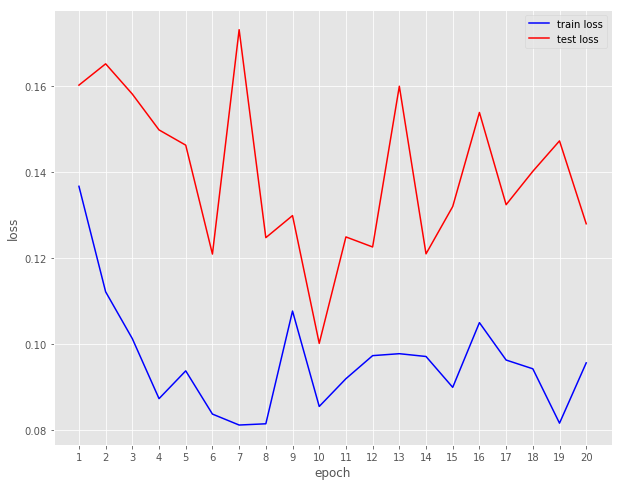

In [7]:
### visualise train and test loss for 20 epochs
visualize_loss(train_loss, test_loss, nr_epochs)

### Part 2: Actual vs. predicted output


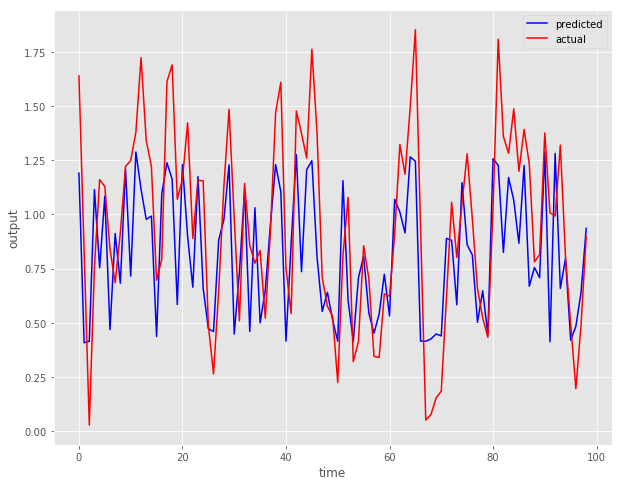

In [8]:
matplotlib.style.use('ggplot')
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111)
ax.set_xlabel('time')
ax.set_ylabel('output')
new_inputs = inputs[1:100]
pred_inputs = model(new_inputs).data
actual_inputs = labels[1:100]
predicted, = plt.plot(pred_inputs, 'b', label='predicted')
actual, = plt.plot(actual_inputs, 'r',label='actual')
plt.legend([predicted, actual], ['predicted', 'actual'])
plt.show()
